import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy, copy
import torch
import sys
from tqdm.auto import tqdm
from mpl_toolkits.mplot3d import Axes3D
import dynesty, nestle
import random

In [2]:
from parameztimation import *

define parameter

In [3]:
%matplotlib inline
n = 3 # DOF
m = 10 # number of signals
t = 300 # time interval
l = 10 # window length
sigma = 0.01 # noise ratio
Im = np.array([[1, 0.1, 0.01],[0, 0.8, 0.1], [0.01, 0.2, 1.1]]) # inertia/mass matrix
Kp = np.array([[1, 0.1, 0.2],[0.1, 1, 0.1],[0.2, 0.1, 2]]) # stiffness matrix
Kv = np.array([[0.5, 0.2, 0.3],[0.2, 0.3, 0.1],[0.3, 0.1, 0.2]]) # damping matrix
colorlist = ["tab:blue","tab:green","tab:orange"] # color list for each DOF

verify that the Kp is symmetric (A = AT) and positive semi-definite (eigenvalue > 0)

In [4]:
spd_check(Kp)

True

### Generate Fake Signals

generate time array and external force array (assume no Jacobian transformation needed)

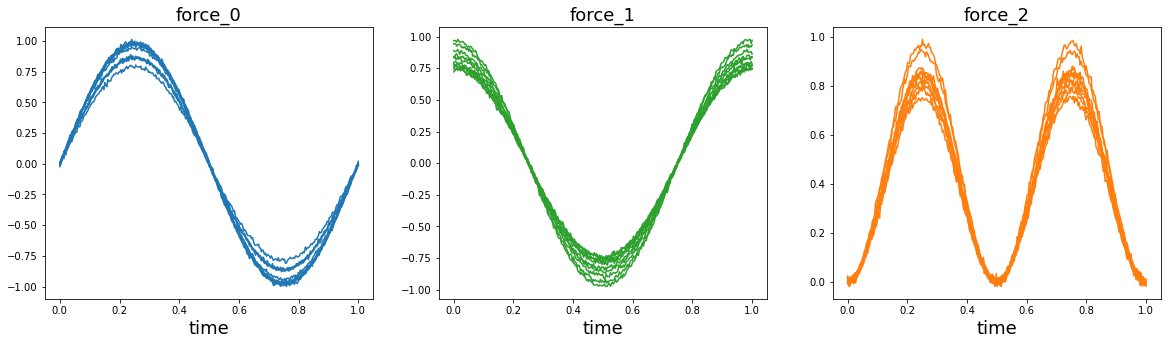

In [5]:
def random_float(low, high):
    return random.random()*(high-low) + low

ts = np.linspace(0,1,t)
fe = []
for i in range(n):
    fei = []
    for j in range(m):
        if (i == 0):
            fei.append(np.random.normal(random_float(0.7,1)*np.sin(2*np.pi*ts),sigma))
        elif (i == 1):
            fei.append(np.random.normal(random_float(0.7,1)*np.cos(2*np.pi*ts),sigma))
        elif (i == 2):
            fei.append(np.random.normal(random_float(0.7,1)*np.power(np.sin(2*np.pi*ts),2),sigma))
    fe.append(np.array(fei))
fe = np.array(fe)

plt.rcParams["figure.figsize"] = (20,5)
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.title("force_"+str(i),fontsize=18)
    plt.plot(ts,fe[i].transpose(),color=colorlist[i])
    plt.xlabel("time",fontsize=18)
plt.show()

use fake ground truth parameters and external force array to generate the trajectories

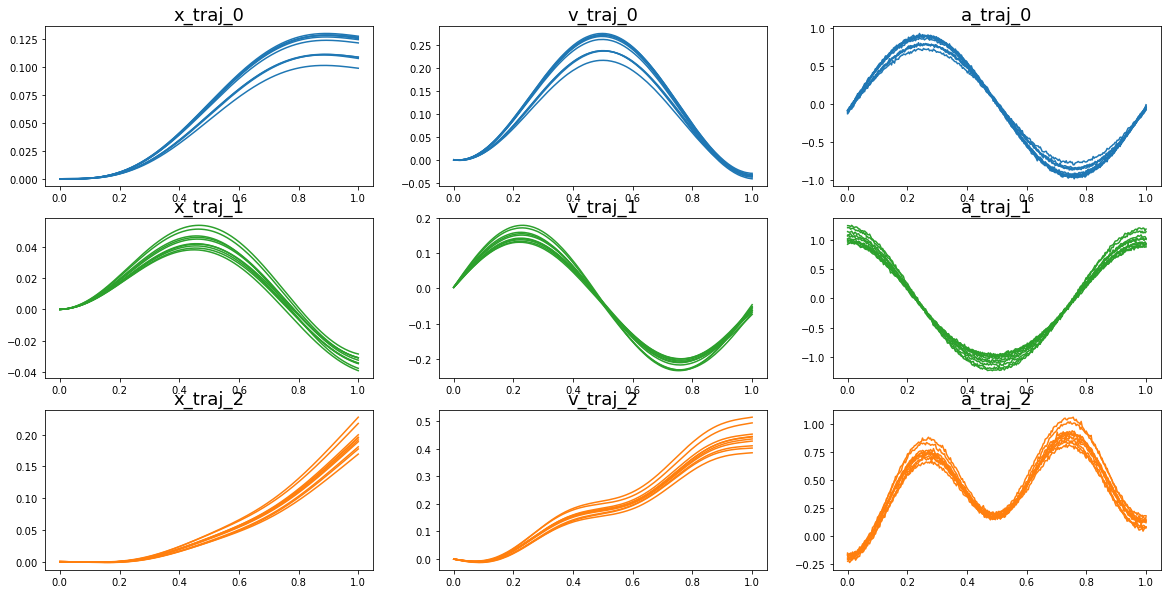

In [6]:
xs = []
dxs = []
ddxs = []
dt = 1/t

xs = np.zeros(fe.shape)
dxs = np.zeros(fe.shape)
ddxs = np.zeros(fe.shape)

for j in range(m):
    xi_ = np.zeros((n,1))
    vi_ = np.zeros((n,1))
    ai_ = np.zeros((n,1))
    for ti in range(0,len(ts)):
        ai_ = np.matmul(np.linalg.inv(Im), np.matmul(Kp,xi_)-np.matmul(Kv,vi_)+np.expand_dims(fe[:,j,ti],-1))
        vi_ = vi_ + ai_*dt
        xi_ = xi_ + vi_*dt
        xs[:,j,ti] = deepcopy(xi_).transpose().squeeze(0)
        dxs[:,j,ti] = deepcopy(vi_).transpose().squeeze(0)
        ddxs[:,j,ti] = deepcopy(ai_).transpose().squeeze(0)

# visualize
xs = np.array(xs)
plt.rcParams["figure.figsize"] = (20,10)
for i in range(n):
    plt.subplot(3,n,3*i+1)
    plt.title("x_traj_"+str(i),fontsize=18)
    plt.plot(ts,xs[i].transpose(),color=colorlist[i])
    plt.subplot(3,n,3*i+2)
    plt.title("v_traj_"+str(i),fontsize=18)
    plt.plot(ts,dxs[i].transpose(),color=colorlist[i])
    plt.subplot(3,n,3*i+3)
    plt.title("a_traj_"+str(i),fontsize=18)
    plt.plot(ts,ddxs[i].transpose(),color=colorlist[i])
plt.show()

## Perform parameter estimation

first, find the average of the trajectory

In [7]:
xs_hat = np.mean(xs,1)
dxs_hat = np.mean(dxs,1)
ddxs_hat = np.mean(ddxs,1)

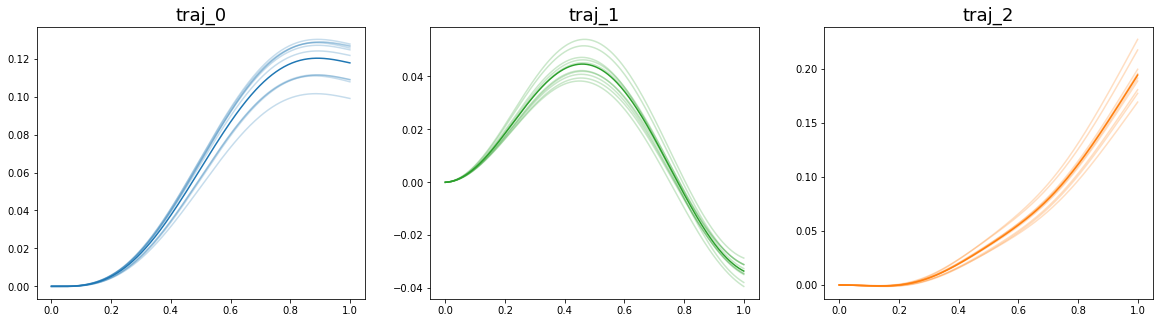

In [8]:
plt.rcParams["figure.figsize"] = (20,5)
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.title("traj_"+str(i),fontsize=18)
    plt.plot(ts,xs[i].transpose(),color=colorlist[i],alpha=0.25)
    plt.plot(ts,xs_hat[i].transpose(),color=colorlist[i],alpha=1)
plt.show()

In [9]:
Kps, Kvs, Ims = estimate_parameter(ts,xs_hat,xs,dxs,ddxs,fe,window_size=l,loss_threshold=0.00001,learning_rate=2,estimatedKv=None,estimatedIm=Im,correction=True,verbose=False)      

### Reconstruction the trajectory using the estimated parameter

In [10]:
exs, dexs, ddexs = reconstruct_trajectories(ts,xs_hat,fe,Kps,Kvs,Ims)    

### Visualize the reconstructed trajectories

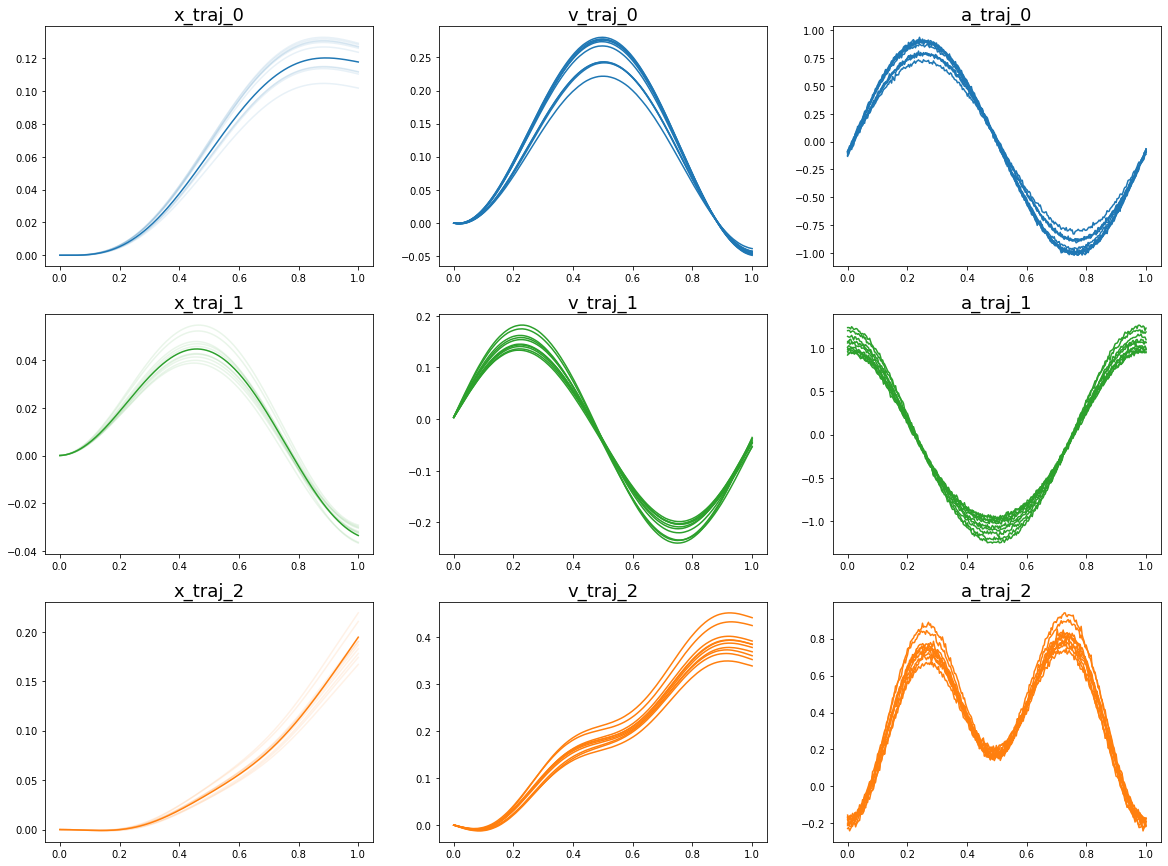

In [11]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,15)
for i in range(n):
    plt.subplot(3,n,3*i+1)
    plt.title("x_traj_"+str(i),fontsize=18)
    plt.plot(ts,exs[i,:,:].transpose(),color=colorlist[i],alpha=0.1)
    plt.plot(ts,xs_hat[i,:].transpose(),color=colorlist[i])
    plt.subplot(3,n,3*i+2)
    plt.title("v_traj_"+str(i),fontsize=18)
    plt.plot(ts,dexs[i,:,:].transpose(),color=colorlist[i])
    plt.subplot(3,n,3*i+3)
    plt.title("a_traj_"+str(i),fontsize=18)
    plt.plot(ts,ddexs[i,:,:].transpose(),color=colorlist[i])
plt.show()

### Visualize parameter eplisoid

visualize stiffness coefficient

D:\SDU\courses\F22_ProjectInAdvancedRobotics\encode-task-impedance-from-demonstration\parameter_estimation\parameztimation.py:340: RuntimeWarning: invalid value encountered in sqrt
  plot_ellipsoid_3d(np.array(x)*gain,evec*np.sqrt(lamb), ax)
D:\SDU\courses\F22_ProjectInAdvancedRobotics\encode-task-impedance-from-demonstration\parameter_estimation\parameztimation.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  x[i,j], y[i,j], z[i,j] = center + np.dot(axes, [x[i,j],y[i,j],z[i,j]])


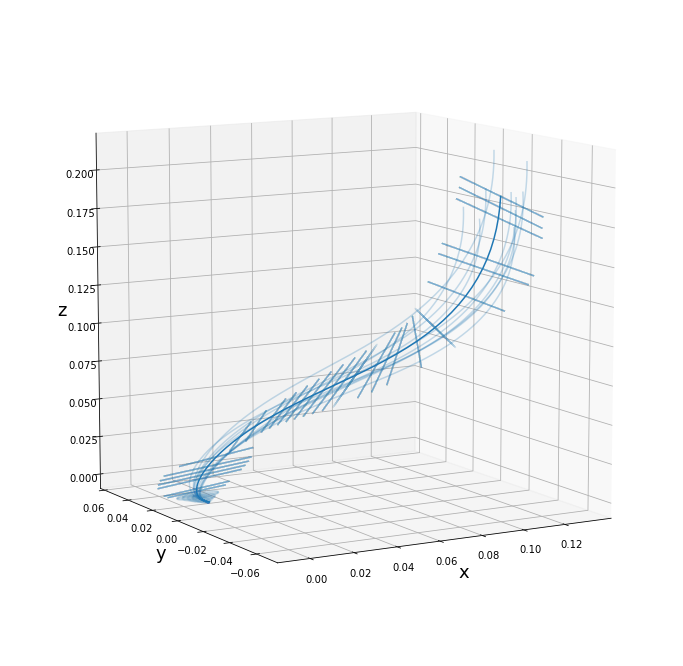

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(12., 12.))

ax = fig.add_subplot(111, projection='3d')

# plot parameter ellipsoid
plot_param_ellipsoid(ax,Kps,xs_hat,exs,step=5,tmax=len(ts),window_size=l,gain=1)

ax.view_init(elev=10., azim=-120)

plt.show()


visualize damping coefficient

D:\SDU\courses\F22_ProjectInAdvancedRobotics\encode-task-impedance-from-demonstration\parameter_estimation\parameztimation.py:340: RuntimeWarning: invalid value encountered in sqrt
  plot_ellipsoid_3d(np.array(x)*gain,evec*np.sqrt(lamb), ax)


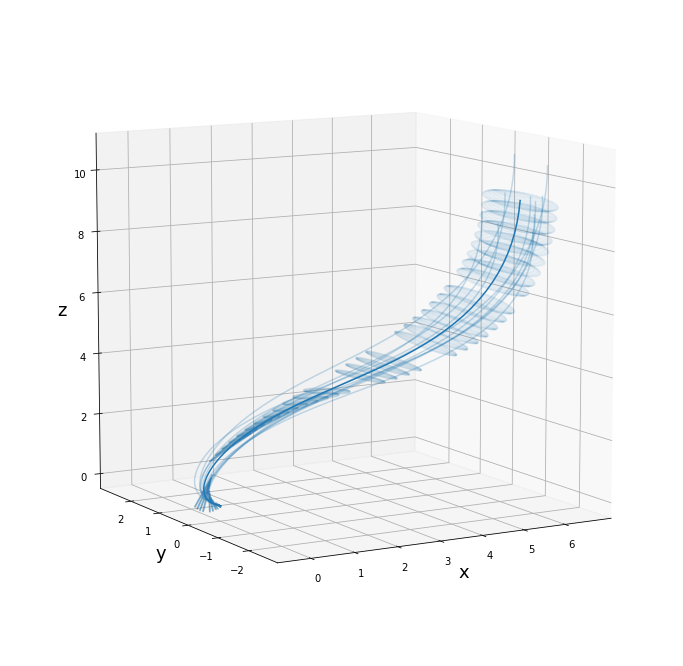

In [13]:
%matplotlib inline
fig = plt.figure(figsize=(12., 12.))

ax = fig.add_subplot(111, projection='3d')

# plot parameter ellipsoid
plot_param_ellipsoid(ax,Kvs,xs_hat,exs,step=5,tmax=len(ts),window_size=l,gain=50)

ax.view_init(elev=10., azim=-120)

plt.show()


visualize inertial/mass matrix

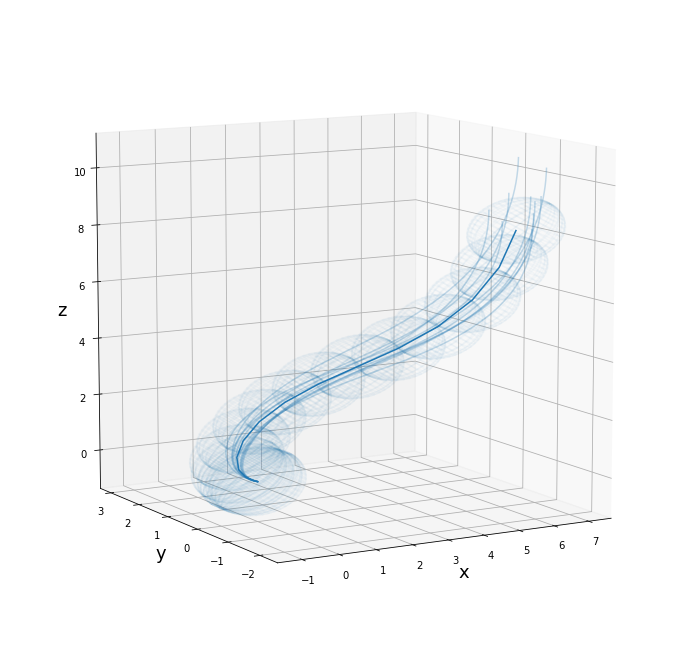

In [14]:
%matplotlib inline
fig = plt.figure(figsize=(12., 12.))

ax = fig.add_subplot(111, projection='3d')

# plot parameter ellipsoid
plot_param_ellipsoid(ax,Ims,xs_hat,exs,step=20,tmax=len(ts),window_size=l,gain=50)

ax.view_init(elev=10., azim=-120)

plt.show()


jupyter nbconvert --execute --to markdown README.ipynb